<img src="../Pics/MLSb-T.png" width="160">
<br><br>
<center><u><H1>Emotion Recognition with LSTM and Attention</H1></u></center>

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [2]:
from keras import Model, Input
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, Dropout, TimeDistributed, Reshape, Activation, Dot
from keras.layers.wrappers import Bidirectional
from keras.utils import to_categorical
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
from IPython.core.display import display, HTML
%matplotlib inline

In [3]:
df = pd.read_csv("../data/emotions/emotion.data")
df.head(10)

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love
5,18231,i find myself frustrated with christians becau...,love
6,10714,i am one of those people who feels like going ...,joy
7,35177,i feel especially pleased about this as this h...,joy
8,122177,i was struggling with these awful feelings and...,joy
9,26723,i feel so enraged but helpless at the same time,anger


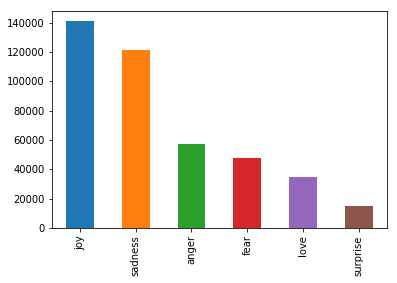

In [4]:
df.emotions.value_counts().plot.bar()

In [5]:
text_tokens = [text.split(" ") for text in df["text"].values.tolist()]
text = df["text"].values.tolist()
labels = df["emotions"].values.tolist()

In [6]:
print(df['text'][0])

i feel awful about it too because it s my job to get him in a position to succeed and it just didn t happen here


In [7]:
print(text_tokens[0])

['i', 'feel', 'awful', 'about', 'it', 'too', 'because', 'it', 's', 'my', 'job', 'to', 'get', 'him', 'in', 'a', 'position', 'to', 'succeed', 'and', 'it', 'just', 'didn', 't', 'happen', 'here']


In [8]:
print(labels[0])

sadness


In [9]:
tokenizer = Tokenizer()

In [10]:
tokenizer.fit_on_texts(text)

In [11]:
word2id = tokenizer.word_index
id2word = dict([(value, key) for (key, value) in word2id.items()])

In [12]:
print(word2id)

{'i': 1, 'feel': 2, 'and': 3, 'to': 4, 'the': 5, 'a': 6, 'feeling': 7, 'that': 8, 'of': 9, 'my': 10, 'in': 11, 'it': 12, 'like': 13, 'so': 14, 'for': 15, 'im': 16, 'have': 17, 'me': 18, 'but': 19, 'was': 20, 'is': 21, 'this': 22, 'am': 23, 'with': 24, 'not': 25, 'be': 26, 'about': 27, 'as': 28, 'on': 29, 'you': 30, 'just': 31, 'when': 32, 'at': 33, 'or': 34, 'all': 35, 'because': 36, 'more': 37, 'do': 38, 'can': 39, 'really': 40, 'up': 41, 't': 42, 'know': 43, 'by': 44, 'are': 45, 'very': 46, 'been': 47, 'out': 48, 'myself': 49, 'what': 50, 'if': 51, 'time': 52, 'how': 53, 'get': 54, 'little': 55, 'will': 56, 'had': 57, 'now': 58, 'from': 59, 'being': 60, 'people': 61, 'they': 62, 'would': 63, 'he': 64, 'her': 65, 'want': 66, 'one': 67, 'think': 68, 'them': 69, 'still': 70, 'some': 71, 'ive': 72, 'even': 73, 'who': 74, 'much': 75, 'an': 76, 'we': 77, 'life': 78, 'him': 79, 'its': 80, 'there': 81, 'something': 82, 's': 83, 'things': 84, 'way': 85, 'bit': 86, 'm': 87, 'make': 88, 'love':

In [13]:
vocab_size = len(word2id) + 1
vocab_size

75303

## Generating data:

In [14]:
embedding_dim = 100
max_len = 150

In [15]:
X = [[word2id[word] for word in sent] for sent in text_tokens]
print(X[0])

[1, 2, 472, 27, 12, 94, 36, 12, 83, 10, 329, 4, 54, 79, 11, 6, 1159, 4, 2967, 3, 12, 31, 260, 42, 538, 134]


In [16]:
pad = 'post'
X_pad = pad_sequences(X, maxlen=max_len, padding=pad, truncating=pad)

In [17]:
print(X_pad[0])

[   1    2  472   27   12   94   36   12   83   10  329    4   54   79
   11    6 1159    4 2967    3   12   31  260   42  538  134    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [18]:
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'anger', 1: 'sadness', 2: 'fear', 3: 'surprise', 4: 'joy', 5: 'love'}

In [19]:
y = [label2id[label] for label in labels]

In [20]:
y = to_categorical(y, num_classes=len(label2id), dtype='float32')

In [21]:
print("X (shape): {}".format(X_pad.shape))
print("y (shape): {}".format(y.shape))

X (shape): (416809, 150)
y (shape): (416809, 6)


## Creating the model:

In [22]:
seq_input = Input(shape=(max_len,), dtype='int32')

In [23]:
embedded = Embedding(vocab_size,
                     embedding_dim,
                     input_length=max_len)(seq_input)

In [24]:
embedded = Dropout(0.2)(embedded)

In [25]:
lstm = Bidirectional(CuDNNLSTM(embedding_dim, return_sequences=True))(embedded)

In [26]:
lstm = Dropout(0.2)(lstm)

### Attention mechanism:

In [27]:
att_vector = TimeDistributed(Dense(1))(lstm)

In [28]:
att_vector = Reshape((max_len,))(att_vector)

In [29]:
att_vector = Activation('softmax', name='attention_vec')(att_vector)

In [30]:
att_output = Dot(axes=1)([lstm, att_vector])

### Final layers:

In [31]:
fc = Dense(embedding_dim, activation='relu')(att_output)

In [32]:
output = Dense(len(label2id), activation='softmax')(fc)

In [33]:
model = Model(inputs=[seq_input], outputs=output)

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 100)     7530300     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 150, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 150, 200)     161600      dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

## Compiling the model:

In [35]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

## Training the model:

In [36]:
%%time
model.fit(X_pad, y, epochs=2, batch_size=64, validation_split=0.2, shuffle=True, verbose=2)

Train on 333447 samples, validate on 83362 samples
Epoch 1/2
 - 166s - loss: 0.2103 - acc: 0.8969 - val_loss: 0.0953 - val_acc: 0.9403
Epoch 2/2
 - 149s - loss: 0.0915 - acc: 0.9409 - val_loss: 0.0925 - val_acc: 0.9408
Wall time: 5min 15s


## Loading the Attention Layer:

In [37]:
model_att = Model(inputs=model.input,
                  outputs=[model.output, model.get_layer('attention_vec').output])

## Testing with a sample text:

In [38]:
sample_text = random.choice(df["text"].values.tolist())
print(sample_text)

i feel cheated by powell s casual shooting of both our fox and our vixen we loyal readers deserve and have earned a longer and bloodier hunt


In [39]:
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]

In [40]:
encoded_samples = pad_sequences(encoded_samples, maxlen=max_len)

In [41]:
label_probs, attentions = model_att.predict(encoded_samples)

### Probabilities for each class:

In [42]:
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}

print(label_probs)

{'anger': 1.0356959e-05, 'sadness': 4.3637015e-06, 'fear': 1.8722354e-06, 'surprise': 1.01915184e-07, 'joy': 0.99998283, 'love': 4.989065e-07}


### Attention vector in the text:

In [43]:
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = attention_score

print(token_attention_dic)

{'i': 5.6322107e-05, 'feel': 0.055309992, 'cheated': 0.04871401, 'by': 0.21289816, 'powell': 0.46180916, 's': 0.20244385, 'casual': 0.0002389713, 'shooting': 0.0018685575, 'of': 0.0011218569, 'both': 0.000100906196, 'our': 0.00019262519, 'fox': 0.00028492464, 'and': 0.0004157015, 'vixen': 0.00038754515, 'we': 0.00058060634, 'loyal': 0.0068788426, 'readers': 0.00076337316, 'deserve': 0.00042612795, 'have': 0.0003859923, 'earned': 0.0006879167, 'a': 0.00061064056, 'longer': 0.0005008494, 'bloodier': 0.0008889065, 'hunt': 0.00060200767}


## Visualization:

In [44]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

In [45]:
def attention_color(attention_score):
    c = 255 - int(attention_score * 255)
    color = rgb_to_hex((c,255,c))
    return str(color)

### Visualizing attentions

In [46]:
html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for word, att in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention_color(att), word)
html_text += "</p>"

In [47]:
display(HTML(html_text))

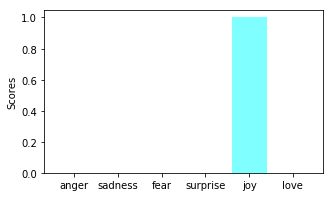

In [48]:
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,3))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['pink', 'red', 'orange', 'brown', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()